In [ ]:
# import tensorflow as tf

In [ ]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

In [ ]:
# os.chdir("/mnt/")
import neuraluq.neuraluq as neuq
import neuraluq.neuraluq.variables as neuq_vars
from neuraluq.neuraluq.config import tf

import numpy as np
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [ ]:
!git clone https://github.com/Annaantonin/Data.git

In [ ]:
rm -rf Data

In [ ]:
import Data as data
# data = sio.loadmat("Data/sdof_2000.mat")

In [ ]:
!git clone https://github.com/Crunch-UQ4MI/neuraluq.git
#!git clone https://github.com/Annaantonin/Data.git
!pip install tensorflow-probability
!pip install scipy
import os
os.chdir("/tf/neuraluq/")
!python setup.py install

In [ ]:
os.listdir(".")

In [117]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct  4 16:14:30 2023

@author: Antonina
"""
################################################   With Unknown Force###########################
#%%
# Simulated SDOF with:
#K_true=10;
# C_true=0.2236; %system damping ratio 5%
# m=5; %mass for sdof example

def load_data(noise):

    #data = sio.loadmat(r"G:\My Drive\Python_codes\NNs\sdof_ymeas.mat")
    data = sio.loadmat("Data/sin_force_noise.mat")
    #  t_x_train, t_f_train = data["t"], data["ymeas"]
    # data = matdata['data']
    x_tt_train, t_train = data["a"], data["t"]
    x_train, f_train = data["u"], data["force"]
    # Input_train=t, x_tt
    # train_x_tt = t_x_tt_train, x_train
    # train_f = t_f_train, f_train

    return  x_tt_train, t_train.T, x_train, f_train.T

#m=1
# [0][..., 0:1]     

def pde_fn(t, x, f, log_c, log_k):
    # log_k=tf.clip_by_value(log_k,np.log(0),np.log(20)) # to make constraints for the parameters
    # log_c=tf.clip_by_value(log_c,np.log(0),np.log(0.5))
    x_t = tf.gradients(x, t)     #velocity                                                                                                                                                                                                                   
    # x_tt = tf.gradients(x_t, t) [0]
    m=5 
    x_tt=(f-tf.exp(log_c) * x_t - tf.exp(log_k) * x)/m
    # f - tf.multiply(x_tt, 5.0)+ tf.exp(log_c) * x_t + tf.exp(log_k) * x
    # return [f,x_tt]
    return x_tt

def pde_xtt(t,x):
    x_t = tf.gradients(x, t)                                                                                                                                                                                                               
    x_tt = tf.gradients(x_t, t) 
    
    return x_tt


def pde_init(init,x):
    x0=5
    return x0-x[0]
    
@neuq.utils.timer
def Trainable(
   x_tt_train, t_train, x_train, f_train, noise, layers, 
):
    # build processes
  
    process_x = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        posterior=neuq_vars.fnn.Trainable(layers=layers, regularizer=tf.keras.regularizers.l2(1e-5)),# displacement
    
    )
    process_f = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),  #, activation=tf.sigmoid
        posterior=neuq_vars.fnn.Trainable( layers=layers), #, regularizer=tf.keras.regularizers.l2(1e-5)
    )
    
    process_log_c = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_log_k = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    method = neuq.inferences.DEns(
        num_samples=3, num_iterations=10000, optimizer=tf.train.AdamOptimizer(1e-3),
    )

    # posterior = neuq_vars.pfnn.Trainable(
    #     layers=layers, num=10, regularizer=tf.keras.regularizers.l2(1e-5),
    # )
    
    # method = neuq.inferences.DEns(
    #     num_iterations=10000,
    #     optimizer=tf.train.AdamOptimizer(1e-3),
    #     is_parallelized=True,
    # )
    # build losses
    loss_x = neuq.likelihoods.MSE(
        inputs=t_train,
        targets=x_tt_train, # could be the problem
        processes=[process_x],
        pde=pde_xtt, # dotdot _X
        multiplier=1,
    )
    
    loss_f = neuq.likelihoods.MSE(
        inputs=t_train,
        targets=x_tt_train, # minimizing the loss to be close to zero
         # targets=np.zeros_like(t_train), # minimizing the loss to be close to zero
        processes=[process_x, process_f, process_log_c, process_log_k], # tf train
        pde=pde_fn,
        multiplier=1,
    )
    loss_init = neuq.likelihoods.MSE(
        inputs=np.zeros_like(t_train),
        targets=np.zeros_like(t_train), # minimizing the loss to be close to zero
         # targets=np.zeros_like(t_train), # minimizing the loss to be close to zero
        processes=[process_x], # tf train
        pde=pde_init,
        multiplier=1,
    )   
    
    
    # build model
    model = neuq.models.Model(
        processes=[process_x, process_f, process_log_c, process_log_k],
        likelihoods=[loss_x, loss_f, loss_init],
    )
    # assign and compile method
    model.compile(method)
    # obtain posterior samples
    samples = model.run()
    # samples,results = model.run()
    # print("Acceptance rate: %.3f \n" % (np.mean(results)))
    
    processes = [process_x, process_f, process_log_c, process_log_k]
    return processes, samples, model


if __name__ == "__main__":

    noise = 0

    x_tt_train, t_train, x_train, f_train = load_data(noise)

    # t_x_tt_train, x_tt_train = train_x_tt
    # t_f_train, f_train = train_f

    layers = [1, 50, 50, 1]
    # layers_force = [1, 20, 20, 1]
    processes, samples, model = Trainable(
        x_tt_train, t_train, x_train, f_train, noise, layers, 
    )


    x_pred, f_pred, logc_pred, logk_pred = model.predict(t_train, samples, processes, pde_fn=None)
    (xtt_pred,) = model.predict(t_train, samples, processes, pde_fn=pde_fn)


Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

Generating 0th sample by deep ensemble...
Iteration:  0 , loss:  32.86544
Iteration:  1000 , loss:  1.120784
Iteration:  2000 , loss:  0.6359604
Iteration:  3000 , loss:  0.37596217
Iteration:  4000 , loss:  0.27833125
Iteration:  5000 , loss:  0.2565977
Iteration:  6000 , loss:  0.25217637
Iteration:  7000 , loss:  0.25001243
Iteration:  8000 , loss:  0.24445586
Iteration:  9000 , loss:  0.22758609
Generating 1th sample by deep ensemble...
Iteration:  0 , loss:  32.646477
Iteration:  1000 , loss:  1.2994117
Iteration:  2000 , loss:  0.8950439
Iteration:  3000 , loss:  0.41057727
Iteration:  4000 , loss:  0.2950194
Iteration:  5000 , loss:  0.27003556
Iteration:  6000 , loss:  0.257438
Iteration:  7000 , loss:  0.24800524
Iteration:  8000 , loss:  0.24100904
Iteration:  9000 , loss:  0.22806661
Generating 2th sample by deep ensemble...
Iteration:  0 , loss:  32.681824
Iteration:  1000 , loss:  1.4447424
Iteration:  2

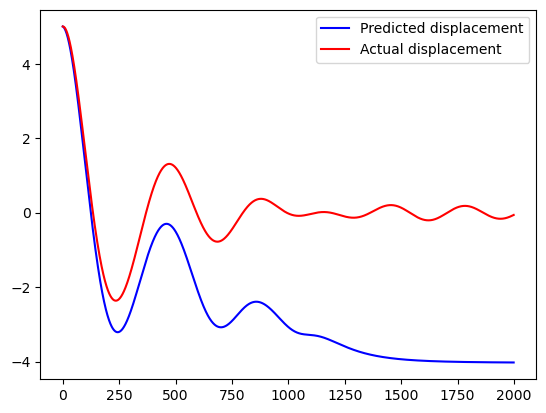

In [118]:
plt.plot(x_pred[0,:,0],'b',label='Predicted displacement')
plt.plot(x_train,'r',label='Actual displacement')
plt.legend()

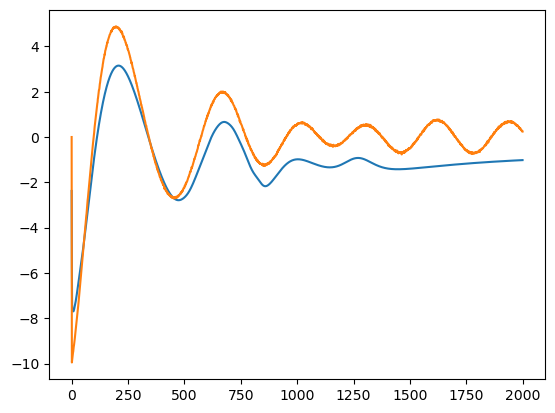

In [119]:
plt.plot(xtt[0,0,:])
plt.plot(x_tt_train)

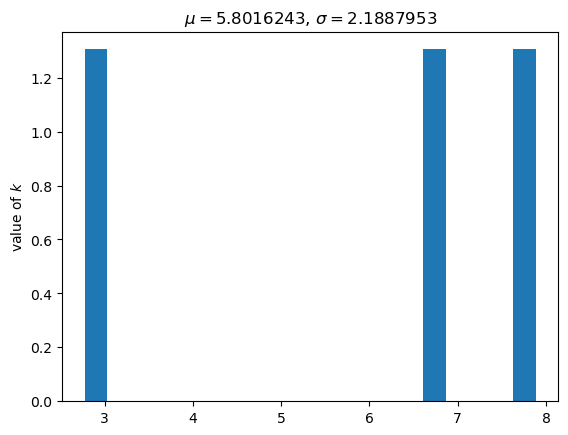

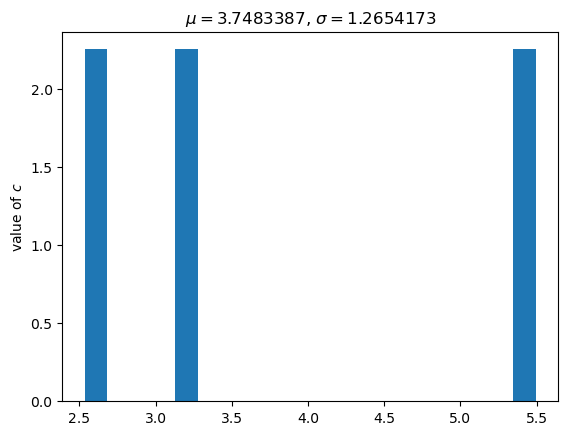

In [120]:
neuq.utils.hist(np.exp(logk_pred).flatten(), name="value of $k$")
neuq.utils.hist(np.exp(logc_pred).flatten(), name="value of $c$")

In [102]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct  4 16:14:30 2023

@author: Antonina
"""
################################################   With Known Force###########################
#%%
# Simulated SDOF with:
#K_true=10;
# C_true=0.2236; %system damping ratio 5%

# m=5; %mass for sdof example

def load_data(noise):

    #data = sio.loadmat(r"G:\My Drive\Python_codes\NNs\sdof_ymeas.mat")
    data = sio.loadmat("Data/sin_force_noise.mat")
    #  t_x_train, t_f_train = data["t"], data["ymeas"]
    # data = matdata['data']
    x_tt_train, t_train = data["a"], data["t"]
    x_train, f_train = data["u"], data["force"]
    # Input_train=t, x_tt
    # train_x_tt = t_x_tt_train, x_train
    # train_f = t_f_train, f_train

    return  x_tt_train, t_train.T, x_train, f_train.T

#m=1
# [0][..., 0:1]     

def pde_fn(t, x,  log_c, log_k):
    # log_k=tf.clip_by_value(log_k,np.log(0),np.log(20)) # to make constraints for the parameters
    # log_c=tf.clip_by_value(log_c,np.log(0),np.log(0.5))
    x_t = tf.gradients(x, t)  [0]   #velocity                                                                                                                                                                                                                   
    x_tt = tf.gradients(x_t, t) [0]
    m=5 
    f=m*x_tt+tf.exp(log_c) * x_t + tf.exp(log_k) * x
    # f - tf.multiply(x_tt, 5.0)+ tf.exp(log_c) * x_t + tf.exp(log_k) * x
    # return [f,x_tt]
    return f

def pde_xtt(t,x):
    x_t = tf.gradients(x, t)    [0]                                                                                                                                                                                                           
    x_tt = tf.gradients(x_t, t) [0]
    
    return x_tt
    
def pde_init(init,x):
    x0=5
    return x0-x[0]
    
@neuq.utils.timer
def Trainable(
   x_tt_train, t_train, x_train, f_train, noise, layers, 
):
    # build processes
  
    process_x = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        posterior=neuq_vars.fnn.Trainable(layers=layers, regularizer=tf.keras.regularizers.l2(1e-5)),# displacement
    
    )
       
    process_log_c = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_log_k = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    method = neuq.inferences.DEns(
        num_samples=3, num_iterations=10000, optimizer=tf.train.AdamOptimizer(1e-3),
    )

    # posterior = neuq_vars.pfnn.Trainable(
    #     layers=layers, num=10, regularizer=tf.keras.regularizers.l2(1e-5),
    # )
    
    # method = neuq.inferences.DEns(
    #     num_iterations=10000,
    #     optimizer=tf.train.AdamOptimizer(1e-3),
    #     is_parallelized=True,
    # )
    # build losses
    loss_x = neuq.likelihoods.MSE(
        inputs=t_train,
        targets=x_tt_train, # could be the problem
        processes=[process_x],
        pde=pde_xtt, # dotdot _X
        multiplier=1,
    )
    
    loss_f = neuq.likelihoods.MSE(
        inputs=t_train,
        targets=f_train, # minimizing the loss to be close to zero
         # targets=np.zeros_like(t_train), # minimizing the loss to be close to zero
        processes=[process_x,  process_log_c, process_log_k], # tf train
        pde=pde_fn,
        multiplier=1,
    )
    
    loss_init = neuq.likelihoods.MSE(
        inputs=np.zeros_like(t_train),
        targets=np.zeros_like(t_train), # minimizing the loss to be close to zero
         # targets=np.zeros_like(t_train), # minimizing the loss to be close to zero
        processes=[process_x], # tf train
        pde=pde_init,
        multiplier=1,
    )
    
    
    # build model
    model = neuq.models.Model(
        processes=[process_x, process_log_c, process_log_k],
        likelihoods=[loss_x, loss_f, loss_init],
    )
    # assign and compile method
    model.compile(method)
    # obtain posterior samples
    samples = model.run()
    # samples,results = model.run()
    # print("Acceptance rate: %.3f \n" % (np.mean(results)))
    
    processes = [process_x,  process_log_c, process_log_k]
    return processes, samples, model


if __name__ == "__main__":

    noise = 0

    x_tt_train, t_train, x_train, f_train = load_data(noise)

    # t_x_tt_train, x_tt_train = train_x_tt
    # t_f_train, f_train = train_f

    layers = [1, 50, 50, 1]
    # layers_force = [1, 20, 20, 1]
    processes, samples, model = Trainable(
        x_tt_train, t_train, x_train, f_train, noise, layers, 
    )


    x_pred,  logc_pred, logk_pred = model.predict(t_train, samples, processes, pde_fn=None)
    (f_pred,) = model.predict(t_train, samples, processes, pde_fn=pde_fn)


Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

Generating 0th sample by deep ensemble...
Iteration:  0 , loss:  31.088745
Iteration:  1000 , loss:  5.448679
Iteration:  2000 , loss:  3.2610705
Iteration:  3000 , loss:  2.7279284
Iteration:  4000 , loss:  2.6517901
Iteration:  5000 , loss:  2.4709651
Iteration:  6000 , loss:  2.1145349
Iteration:  7000 , loss:  1.4380379
Iteration:  8000 , loss:  1.3522974
Iteration:  9000 , loss:  1.3432149
Generating 1th sample by deep ensemble...
Iteration:  0 , loss:  31.204378
Iteration:  1000 , loss:  5.5481296
Iteration:  2000 , loss:  3.366526
Iteration:  3000 , loss:  2.6473348
Iteration:  4000 , loss:  2.5627449
Iteration:  5000 , loss:  2.4851217
Iteration:  6000 , loss:  2.4013536
Iteration:  7000 , loss:  2.3327754
Iteration:  8000 , loss:  2.2648861
Iteration:  9000 , loss:  2.176194
Generating 2th sample by deep ensemble...
Iteration:  0 , loss:  31.04613
Iteration:  1000 , loss:  5.5882964
Iteration:  2000 , loss: 

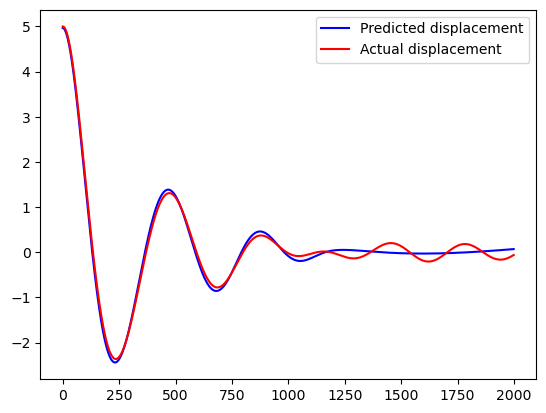

In [103]:
num=2
# [a.shape for a in samples]
# plt.plot(t_train,np.mean(x_pred,axis=(0, 2)),label='Predicted displacement')
# plt.plot(t_train,x_train,'r',label='Actual displacement')
# plt.legend()
# plt.plot(t_train,np.mean(x_pred,axis=(0, 2)),label='Predicted displacement')
# plt.plot(t_train,x_train,'r',label='Actual displacement')
# plt.legend()
x_pred.shape
plt.plot(x_pred[num,:,0],'b',label='Predicted displacement')
plt.plot(x_train,'r',label='Actual displacement')
plt.legend()

In [96]:
# plt.plot(f_pred.flatten())

xtt=np.mean(xtt_pred, axis=3)
xtt.shape

(1, 10, 2000)

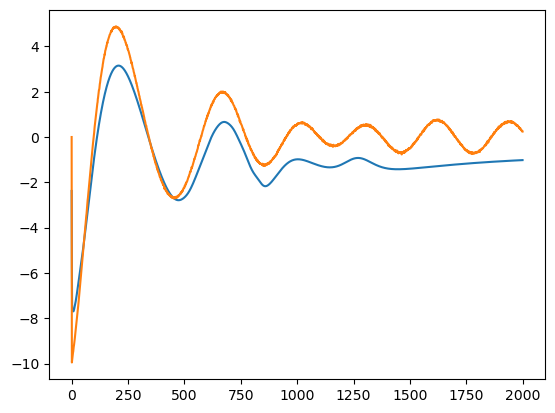

In [104]:
# x_pred, logc_pred, logk_pred = model.predict(t_train, samples, processes, pde_fn=None)
# x_pred, logc_pred, logk_pred = model.predict(t_train, samples, processes, pde_fn=pde_fn)
# f_pred.shape
plt.plot(xtt[0,0,:])
plt.plot(x_tt_train)

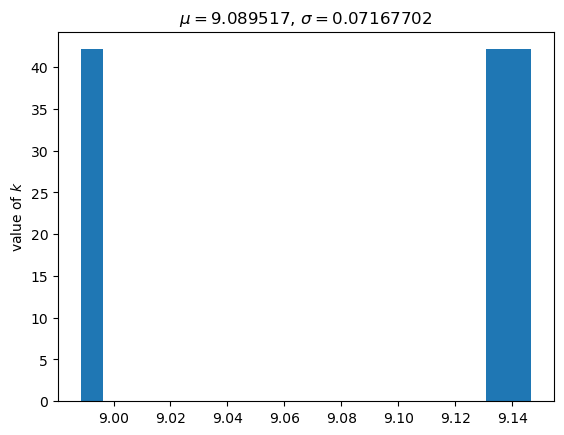

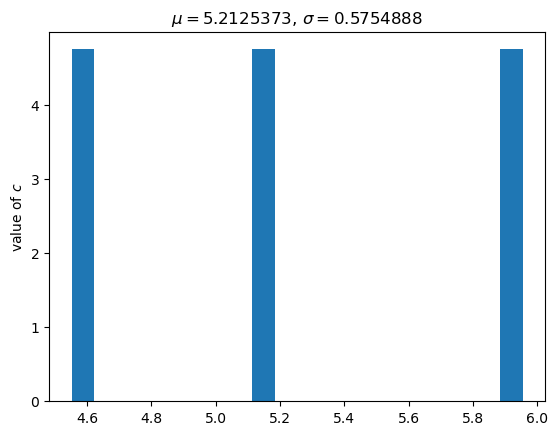

In [101]:
neuq.utils.hist(np.exp(logk_pred).flatten(), name="value of $k$")
neuq.utils.hist(np.exp(logc_pred).flatten(), name="value of $c$")

In [105]:
K_post=np.mean(np.exp(logk_pred))
print("K_true=10(N/m) and K_post =", K_post) 
C_post=np.mean(np.exp(logc_pred))
print("C_true=0.22(Ns/m) and C_post =", C_post) 

K_true=10(N/m) and K_post = 9.41064
C_true=0.22(Ns/m) and C_post = 3.451977
